In [ ]:
!pip install lark-parser --upgrade

## Introduction

Domain-specific languages (DSLs) are languages designed for narrow application contexts. 

Since they are not design to be general-purpose languages (GPLs), they can express relevant information in a terse dialect and with better legibility.

The computer world is full of DSLs. Famous examples include HTML, CSS, SQL, Latex, Markdown, regex, BNF, Make, Maven, Dot, among many many others. Not all DSLs are meant to be executed, like UML, but most are.

The frontier between DSLs and GPLs is not well-defined, being more of a spectrum where languages fit more or less to each side. Arguments can be made that Cobol is a DSL for business applications, or Mathematica is a DSL for doing mathematics, but many classify them as GPLs.

Another distinction can be made between domain-specific APIs and domain-specific languages. One example, in probabilistic programming, is between [PyMC3](https://docs.pymc.io/), a Python module with a rich API to perform probabilistic reasoning, and [Stan](https://mc-stan.org/) which includes a DSL for describing probabilistic models. Both tools solve the same type of problems, but using different perspectives.


## Creating a DSL

Crafting DSLs is not a trivial task. The subject that studies this type of problem is usually called Compilers. A classic book is Aho's et al., [Compilers: Principles, Techniques, and Tools](https://www.amazon.com/dp/0321486811). This is a complex subject, full of subtleties, and is not this notebook's topic. However, some terms are needed for our goals.

Creating a new language has, in broad terms, two stages:

+ Defining a **syntax**, a grammar, to define how to properly write

+ Defining the **semantics**, the meaning, of what it is written

The syntax is usually defined by a recursive expression written in some variant of [Backus–Naur form](https://en.wikipedia.org/wiki/Backus%E2%80%93Naur_form) (BNF), itself a DSL.

The following BNF example describes a grammar to write (simplified) arithmetic expressions,

    expression ::= number | '(' expression operator expression ')'
    operator   ::= '*' | '/'
    number     ::= digit+ | '-' digit+
    digit      ::= '0' | ... | '9'

where `|` means 'or', and `+` means one or more repetitions.

So `(5 * (-12 / 8))` would be accepted, but `(5 + 12)` would not.

A program is needed to convert the textual description written in the accepted grammar (a string) to an appropriate data structure. This type of program is called a **parser**. 

A typical parser translates a string into an [Abstract Syntax Tree](https://en.wikipedia.org/wiki/Abstract_syntax_tree) (AST).

If the language semantics is well-defined, every AST has a particular, well-defined meaning. We then need a program that is able to process any valid AST to produce its expected result.

In the previous arithmetic example the string `(3 * 4)` is transformed into an appropriate AST that, if we assign to operator `*` the meaning of integer multiplication, when executed would result in `12`. On the other hand, if the meaning of `*` is an operation to return a list with repetitions, executing the same AST would result in `[3,3,3,3]`.

To know more, check Sussman and Abelson's book, [Structure and Interpretation of Computer Programs](https://mitpress.mit.edu/sites/default/files/sicp/full-text/book/book.html).

### Using Lark

In [4]:
from lark import Lark

Lark is a Python module developed by Erez Shinan (available at [github](https://github.com/lark-parser/lark)). In his words:

> Lark can parse all context-free languages. To put it simply, it means that it is capable of parsing almost any programming language out there

Lark is able to read a grammar defined in a BNF dialect and parse it to produce the respective AST.

As a simple example, let's create a DSL to represent directed graphs.

An example of our DSL's grammar:

       graph 3
          0 -> 1
          self 2
          1 -> 2

where `graph 5` means a direct graph with five nodes. Each next line represents an edge. There are two types of edges, `0 -> 1` means an edge from node `0` to node `1`, and `self 2` means that the edge starts and ends at node `2`.

So, the first step is to represent this grammar with Lark's BNF dialect:

In [20]:
grammar = """
  start: "graph" NUMBER edges*      
  edges: NUMBER "->" NUMBER    -> edge
       | "self" NUMBER         -> self_edge

  %import common.INT -> NUMBER
  %import common.WS
  %ignore WS  
"""

parser = Lark(grammar)

When we define a new object of class `Lark` given our grammar, we get a parser for the grammar.

Consider the next graph definition, that follows our grammar,

In [21]:
myGraph = """
  graph 5
    0 -> 1
    self 4
    self 2
    1 -> 0
    2 -> 1
    3 -> 0
"""

We can now apply the parser and check the resulting AST:

In [22]:
print(parser.parse(myGraph).pretty())

start
  5
  edge
    0
    1
  self_edge	4
  self_edge	2
  edge
    1
    0
  edge
    2
    1
  edge
    3
    0



The tree nodes were named when the grammar was defined. Each graph description starts on node `start` and have several nodes either of type `self_edge` or `edge`.

The first stage that set the grammar and defines a parser to convert string descriptions into a AST is done.

The second stage is to assign semantics to the AST nodes. We already know which is the meaning of these nodes, they represent edges on our graph.

We needed a Python data structure to represent graphs, and decided to use module `graphviz`, that includes type `Digraph` for directed graphs,

In [23]:
from graphviz import Digraph

Function `run_edge` processes a node of the AST by creating the respective new edge. This is the function that assign semantics to the DSL.

In [38]:
def run_edge(graph, node):
  """
  graph : a Digraph object to be populated
  edge  : a node from AST to be processed and used to create an edge in g
  """
  if node.data == 'edge':
    nd1, nd2 = node.children
    graph.edge(nd1, nd2)
  
  elif node.data == 'self_edge':
    nd = node.children[0]
    graph.edge(nd, nd)

  else:
    raise SyntaxError('Unknown instruction: %s' % node.data)

  return graph

If our AST was more complex, if its nodes had nodes and so on, this function would be recursive, but there's no need here.

Function `processGraph` runs all the stages

In [43]:
def processGraph(graphDescription):
  """
  graphDescription: a graph description string using the DSL grammar
  """
  ast = parser.parse(graphDescription) # make the AST
  n, *edges = ast.children             # get its children
                                       # n is the #nodes, edges the list of edges 
  graph = Digraph()
  for i in range(int(n)):              # create n nodes
    graph.node(str(i))
  for edge in edges:                   # create one edge per iteration
    graph = run_edge(graph, edge)

  return graph

`Digraph` objects have a visualization option, so let's use it to show the graph object created with the DSL descrition:

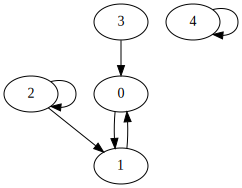

In [44]:
g = processGraph(myGraph)
g

## References

+ Mernik el al., [When and How to Develop Domain-Specific Languages](https://dl.acm.org/doi/10.1145/1118890.1118892) (2005)

+ Erez Shinan, [How to write a DSL (in Python with Lark)](http://blog.erezsh.com/how-to-write-a-dsl-in-python-with-lark/) (2017)